In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee as mc
import corner
from astropy.io import fits
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Loading in the extracted HST data, from my 'HST Image Reduction' notebook
orbit2data = np.load('/home/mmmurphy/data/hd219666b/reduced_data/orbit2_extractednormalizedbroadbanddata.npz')
times_o2 = orbit2data['times']
flux_o2 = orbit2data['broadbandflux']
errs_o2 = orbit2data['broadbanderrs']
orbit3data = np.load('/home/mmmurphy/data/hd219666b/reduced_data/orbit3_extractednormalizedbroadbanddata.npz')
times_o3 = orbit3data['times']
flux_o3 = orbit3data['broadbandflux']
errs_o3 = orbit3data['broadbanderrs']
orbit4data = np.load('/home/mmmurphy/data/hd219666b/reduced_data/orbit4_extractednormalizedbroadbanddata.npz')
times_o4 = orbit4data['times']
flux_o4 = orbit4data['broadbandflux']
errs_o4 = orbit4data['broadbanderrs']

times = np.concatenate([times_o2, times_o3, times_o4])
fluxes = np.concatenate([flux_o2, flux_o3, flux_o4])
errors = np.concatenate([errs_o2, errs_o3, errs_o4])
orbit_ends = np.array([len(times_o2), len(times_o2)+len(times_o3), len(times_o2)+len(times_o3)+len(times_o4)])
# note for the orbit_ends array
# it's defined so that e.g. times[:orbit_ends[0]] returns only values in the second orbit (we don't use first orbit)
#                           times[orbit_ends[0]:orbit_ends[1]] in the third orbit

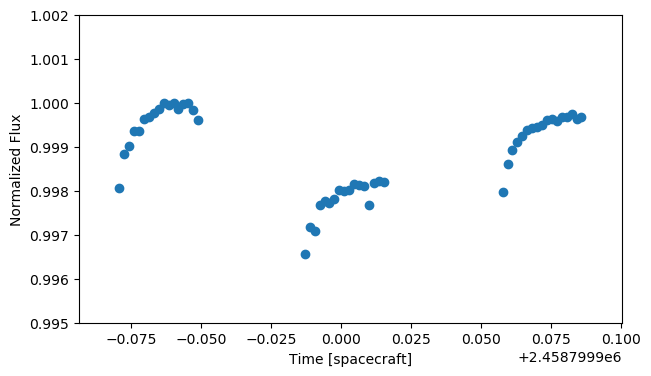

In [7]:
fig, ax = plt.subplots(figsize=(7,4))
ax.scatter(times, fluxes)
ax.set(xlabel='Time [spacecraft]', ylabel='Normalized Flux', ylim=(0.995, 1.002))
plt.show()

In [28]:
##
# Defining my parameter arrays (inits, priors, etc)
#
# General Structure:
# 0 = tc
# 1 = log10P
# 2 = log10(a/Rstar)
# 3 = cos(i)
# 4 = Rp / Rstar
# 5 = hook model amplitude
# 6 = hook model time-scale

labels = np.asarray(['tc', 'log10P', 'log10a', 'cosi', 'RpRs', 'amp1', 'amp2', 'amp3', 'tau1', 'tau2', 'tau3'])
# Priors
lit_tc, lit_tc_unc = 2458329.1996, 0.0012   # [day; bjd tdb]
lit_P, lit_P_unc = 6.034460, 0.000011       # [day]
lit_rprs, lit_rprs_unc = 0.04192, 0.00083   # [Rstar]
lit_a, lit_a_unc = 13.27, 0.39              # [Rstar]
lit_i, lit_i_unc = 86.38, 0.15              # [degrees]
lit_Rp = 4.71          # [Rearth]
lit_e = 0.
lit_w = 90.*(np.pi/180.)  # [radian]

theta_init = np.asarray([
    # Shared orbital parameters 
    lit_tc,                      # 0 - conjunction time
    np.log10(lit_P),             # 1 - log10 Period
    np.log10(lit_a),             # 2 - log10 semi-major axis
    np.cos(lit_i*(np.pi/180.)),  # 3 - cosine inclination
    # Planetary parameters
    lit_rprs,                      # 4 - HST radius
    # HST systematic parameters
    3.e-3,                      # 5 - hook amplitude for orbit 2
    3.e-3,                      # 6 - hook amplitude for orbit 3
    3.e-3,                      # 7 - hook amplitude for orbit 4
    5.e-3,                      # 8 - hook timescale for orbit 2
    5.e-3,                      # 9 - hook timescale for orbit 3
    5.e-3                       # 10 - hook timescale for orbit 4
])

priors = np.asarray([
    # Shared orbital parameters 
    lit_tc,                      # 0 - conjunction time
    np.log10(lit_P),             # 1 - log10 Period
    np.log10(lit_a),             # 2 - log10 semi-major axis
    np.cos(lit_i*(np.pi/180.)),  # 3 - cosine inclination
    # Planetary parameters
    np.inf,                      # 4 - HST radius
    # HST systematic parameters
    np.inf,                      # 5 - hook amplitude
    np.inf,                      # 6
    np.inf,
    np.inf,                      # 8 - hook timescales
    np.inf,
    np.inf                       # 10 
])
# set those which shouldn't have a prior to have value of infinity

c = 1. / np.log(10.)
priorserr = np.asarray([
    # Shared orbital parameters 
    lit_tc_unc,                                          # 0 - conjunction time
    ((c*lit_P_unc)/lit_P),                            # 1 - log10 Period
    ((c*lit_a_unc)/lit_a),                                # 2 - log10 semi-major axis
    np.sin(lit_i*(np.pi/180.))*(lit_i_unc*(np.pi/180.)),  # 3 - cosine inclination
    # Planetary parameters
    lit_rprs_unc,                                         # 4 - HST radius
    # HST systematic parameters
    1.e-4,                                            # 5 - orbit 3&4 hook amplitude
    1.e-4,                                             # 6 - orbit 3&4 hook timescale
    1.e-4,                                               # 7
    1.e-4,                                             # 8
    1.e-4,                                # 9
    1.e-4                                # 10
])

# Initializing the BATMAN model
InitParams = batman.TransitParams()
InitParams.t0 = theta_init[0]      
InitParams.per = 10.**theta_init[1]
InitParams.a = 10.**theta_init[2]
InitParams.inc = np.arccos(theta_init[3])*(180./np.pi)
InitParams.rp = theta_init[4]
InitParams.ecc = 0.
InitParams.w = 90.
InitParams.limb_dark = 'quadratic'
InitParams.u = [0.33, 0.2]
BATMAN_initmodel = batman.TransitModel(InitParams, times)

In [21]:
##
# Defining my astrophysical models

def transit(theta, initmodel):
    # Transit Light curve model
    # Inputs:
    # theta = array of lightcurve parameters
    # initmodel = pre-initialized BATMAN model environment, which increases efficiency
    
    # Unpack input parameters
    tc = theta[0]       # time of conjunction [days]
    log10P = theta[1]   # log10( Period [days] )
    log10a = theta[2]   # log10( a / Rstar )
    cosi = theta[3]     # cosine(inclination [rad])
    rprstar = theta[4]
        
    # Transform input parameters to forms used by BATMAN
    P = 10.**(log10P)  # compute Period in [day]
    a = 10.**(log10a)  # compute a/Rstar
    inc = np.arccos(cosi)*(180./np.pi)  # Compute inclination in [deg]
    ecc = 0.    # use these if assuming circular orbit
    omega = 90.
    
    # Initialize batman parameters
    params = batman.TransitParams()
    params.t0 = tc             # transit midpoint [day]
    params.per = P    # log10 (period [day])
    params.rp = rprstar
    params.a = a      # log10 (semi major axis [Rstar])
    params.inc = inc  # cosine inclination [degrees]
    params.ecc = ecc
    params.w = omega
    
    # Using Esposito's quadratic limb darkening treatment
    params.limb_dark = 'quadratic'
    params.u = [0.33, 0.2]
    
    lightcurve = initmodel.light_curve(params)
    return lightcurve


##
# Defining my systematic models
def hook(theta):
    # Orbit-long charge trapping hook model for HST
    # Inputs:
    # theta = array of lightcurve parameters
    # torbit = time since start of corresponding orbit in units [day]
    
    amplitude_o2 = theta[5]
    amplitude_o3 = theta[6]
    amplitude_o4 = theta[7]
    
    tau_o2 = theta[8]
    tau_o3 = theta[9]
    tau_o4 = theta[10]
    
    # Pull out times [in day; MJD] of each orbit
    orbit2times = times[:orbit_ends[0]]
    orbit3times = times[orbit_ends[0] : orbit_ends[1]]
    orbit4times = times[orbit_ends[1] : orbit_ends[2]]
    
    # From above, compute time since beginning of orbit for each
    tinorbit2 = orbit2times - orbit2times[0]
    tinorbit3 = orbit3times - orbit3times[0]
    tinorbit4 = orbit4times - orbit4times[0]
    
    orbit2hook = 1.0 - amplitude_o2*np.exp(- tinorbit2 / tau_o2)
    orbit3hook = 1.0 - amplitude_o3*np.exp(- tinorbit3 / tau_o3)
    orbit4hook = 1.0 - amplitude_o4*np.exp(- tinorbit4 / tau_o4)
    
    hookcurve = np.concatenate((orbit2hook, orbit3hook, orbit4hook)) 
    return hookcurve

In [22]:
def logLikelihood(ydata, yerr, modely):
    
    likelihoodarray = -0.5*((ydata-modely)**2/(yerr**2)) - np.log(np.sqrt(2.*np.pi*yerr*yerr))
    lnL = np.sum(likelihoodarray)
    
    return lnL

def logPriors(theta, priors, priorserr):
    
    # Limits on certain parameters
    
    # compute priors
    lnP = 0.
    for i, priorval in enumerate(priors):
        if np.isinf(priorval):
            # If not applying a prior on a parameter, it's listed as inf in the array
            continue
        else:
            lnP += -0.5*((priorval-theta[i])**2/(priorserr[i]**2)) - np.log(np.sqrt(2.*np.pi*priorserr[i]*priorserr[i]))
    
    return lnP

def lnPosterior(theta):
    
    prior_array = priors
    priorerrs_array = priorserr
    flux_array = fluxes
    unc_array = errors
    
    # Compute and check priors
    lnPrior_value = logPriors(theta, prior_array, priorerrs_array)
    if not np.isfinite(lnPrior_value):
        return -np.inf
    
    # Compute models
    HSTtransit = transit(theta, BATMAN_initmodel)
    HSThook = hook(theta)
    model = HSTtransit * HSThook

    # Compute likelihoods
    lnLikelihood = logLikelihood(flux_array, unc_array, model)

    # Compute posterior
    lnPost = lnPrior_value + lnLikelihood
    
    if np.isnan(lnPost):
        return -np.inf
    else:
        return lnPost

-3095.0765295665897


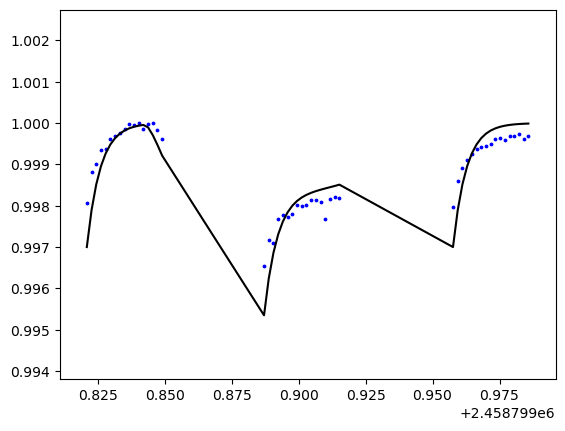

In [23]:
transit_model = transit(theta_init, BATMAN_initmodel)
hook_model = hook(theta_init)
model = transit_model * hook_model

lnPost_init = lnPosterior(theta_init)
print(lnPost_init)
plt.scatter(times, fluxes, c='blue', s=3)
plt.plot(times, model, c='black')
plt.show()

In [44]:
######################################
# Setting up and initializing MCMC

Ndimensions = len(theta_init)
Nwalkers = 3*Ndimensions
Nsteps = 30000

# Initializing walker positions
pos = np.zeros((Nwalkers, Ndimensions))

try:
    # if we ran this before, initialize based on previous run's best fits
    for i in range(Ndimensions):
        pos[:,i] = param_fits[i] + 0.5*np.random.normal(0., param_uperrs[i], Nwalkers)
except:
    # if not, then use theta_init array
    for i in range(Ndimensions):
        pos[:,i] = theta_init[i] + 0.5*np.random.normal(0., priorserr[i], Nwalkers)
    


In [45]:
with Pool() as pool: 
    sampler = mc.EnsembleSampler(Nwalkers, Ndimensions, lnPosterior, pool=pool)
    sampler.run_mcmc(pos, Nsteps, progress=True);

100%|██████████| 30000/30000 [01:15<00:00, 399.05it/s]


In [60]:
samples = sampler.get_chain()
flatsamples = sampler.get_chain(flat=True)
loglikelihoods = sampler.get_log_prob(flat=True)
#autocorrtimes = sampler.get_autocorr_time()

burn = 1000
samples = samples[burn:]
flatsamples = flatsamples[burn*Nwalkers:]
loglikelihoods = loglikelihoods[burn*Nwalkers:]

param_fits = np.asarray([np.median(flatsamples[:,i]) for i in range(samples.shape[2])])
param_uperrs = np.asarray([np.percentile(flatsamples[:,i], 84) for i in range(samples.shape[2])]) - param_fits
param_loerrs = param_fits - np.asarray([np.percentile(flatsamples[:,i], 16) for i in range(samples.shape[2])])

# Generating models with best-fit parameters
bf_transit = transit(param_fits, BATMAN_initmodel)
bf_hook = hook(param_fits)
bf_model = bf_transit * bf_hook

detflux = fluxes / bf_hook
deterrs = errors / bf_hook

# Generating a smooth transit light curve with best-fit parameters for plotting purposes
times_smooth = np.linspace(times[0], times[-1], 100)
BFParams = batman.TransitParams()
BFParams.t0 = param_fits[0]      
BFParams.per = 10.**param_fits[1]
BFParams.a = 10.**param_fits[2]
BFParams.inc = np.arccos(param_fits[3])*(180./np.pi)
BFParams.rp = param_fits[4]
BFParams.ecc = 0.
BFParams.w = 90.
BFParams.limb_dark = 'quadratic'
BFParams.u = [0.33, 0.2]
BATMAN_smoothmodel = batman.TransitModel(BFParams, times_smooth)
transit_smooth = transit(param_fits, BATMAN_smoothmodel)

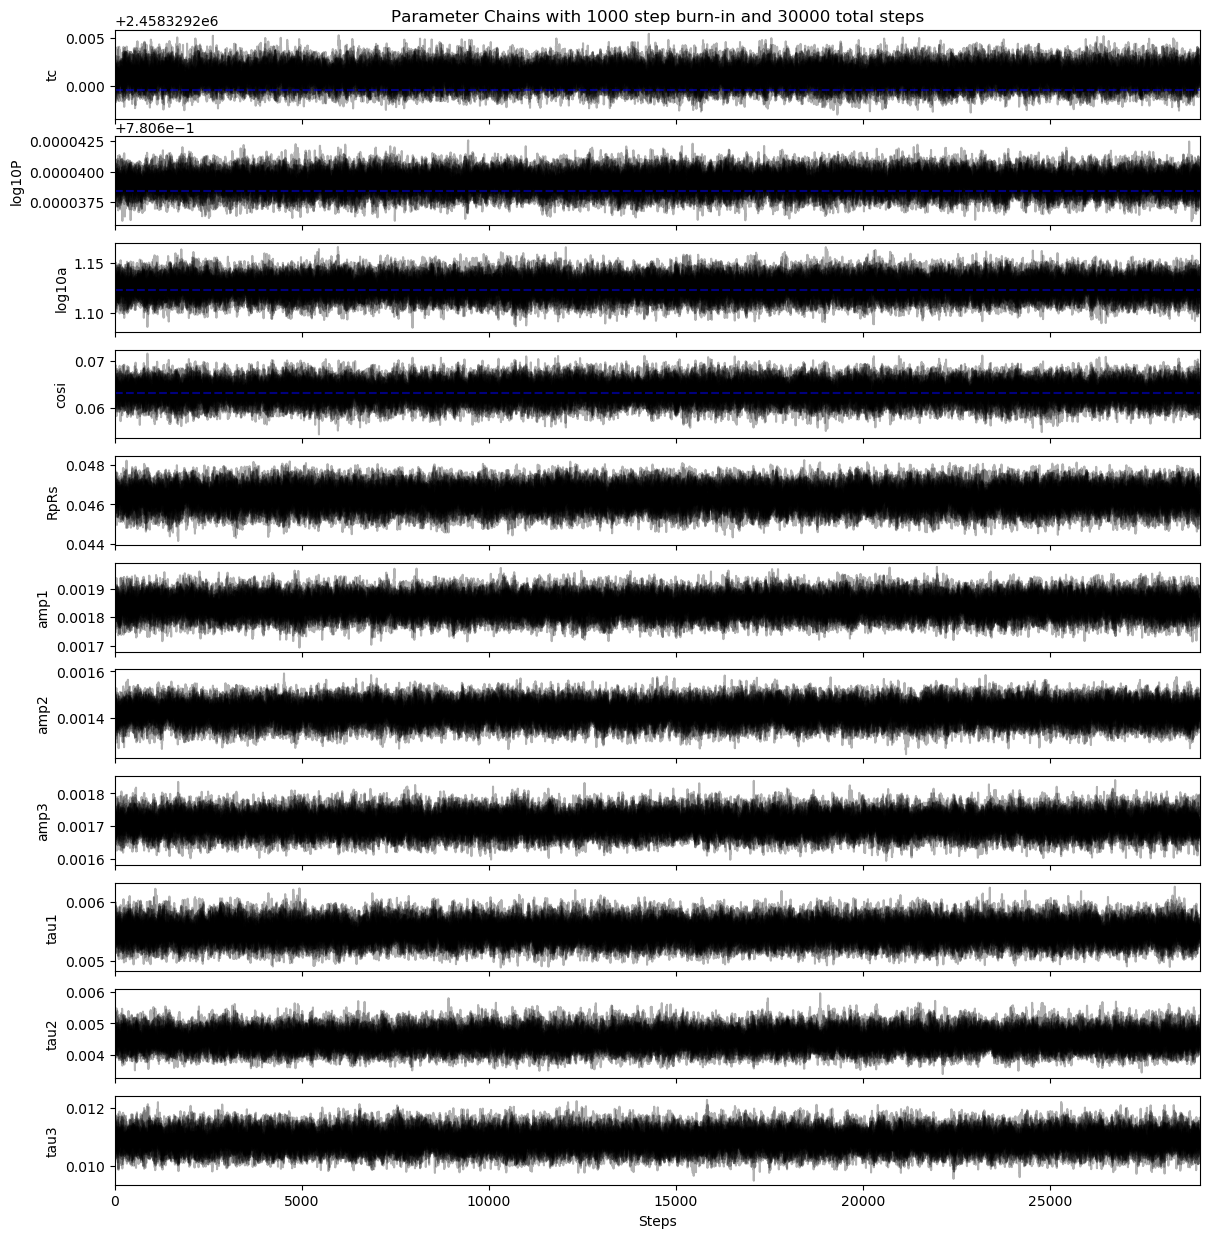

In [48]:
fig, axes = plt.subplots(samples.shape[2], figsize=(14,15), sharex=True)
for i in range(samples.shape[2]):
    ax = axes[i]
    ax.plot(samples[:,:,i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.axhline(priors[i], c='blue', ls='--', alpha=0.5)
    
axes[0].set_title('Parameter Chains with %d step burn-in and %d total steps'%(burn, Nsteps))
axes[-1].set_xlabel('Steps')
plt.savefig('figures/HSTbroadbandfit_chains.png', dpi=300, bbox_inches='tight')
plt.show()

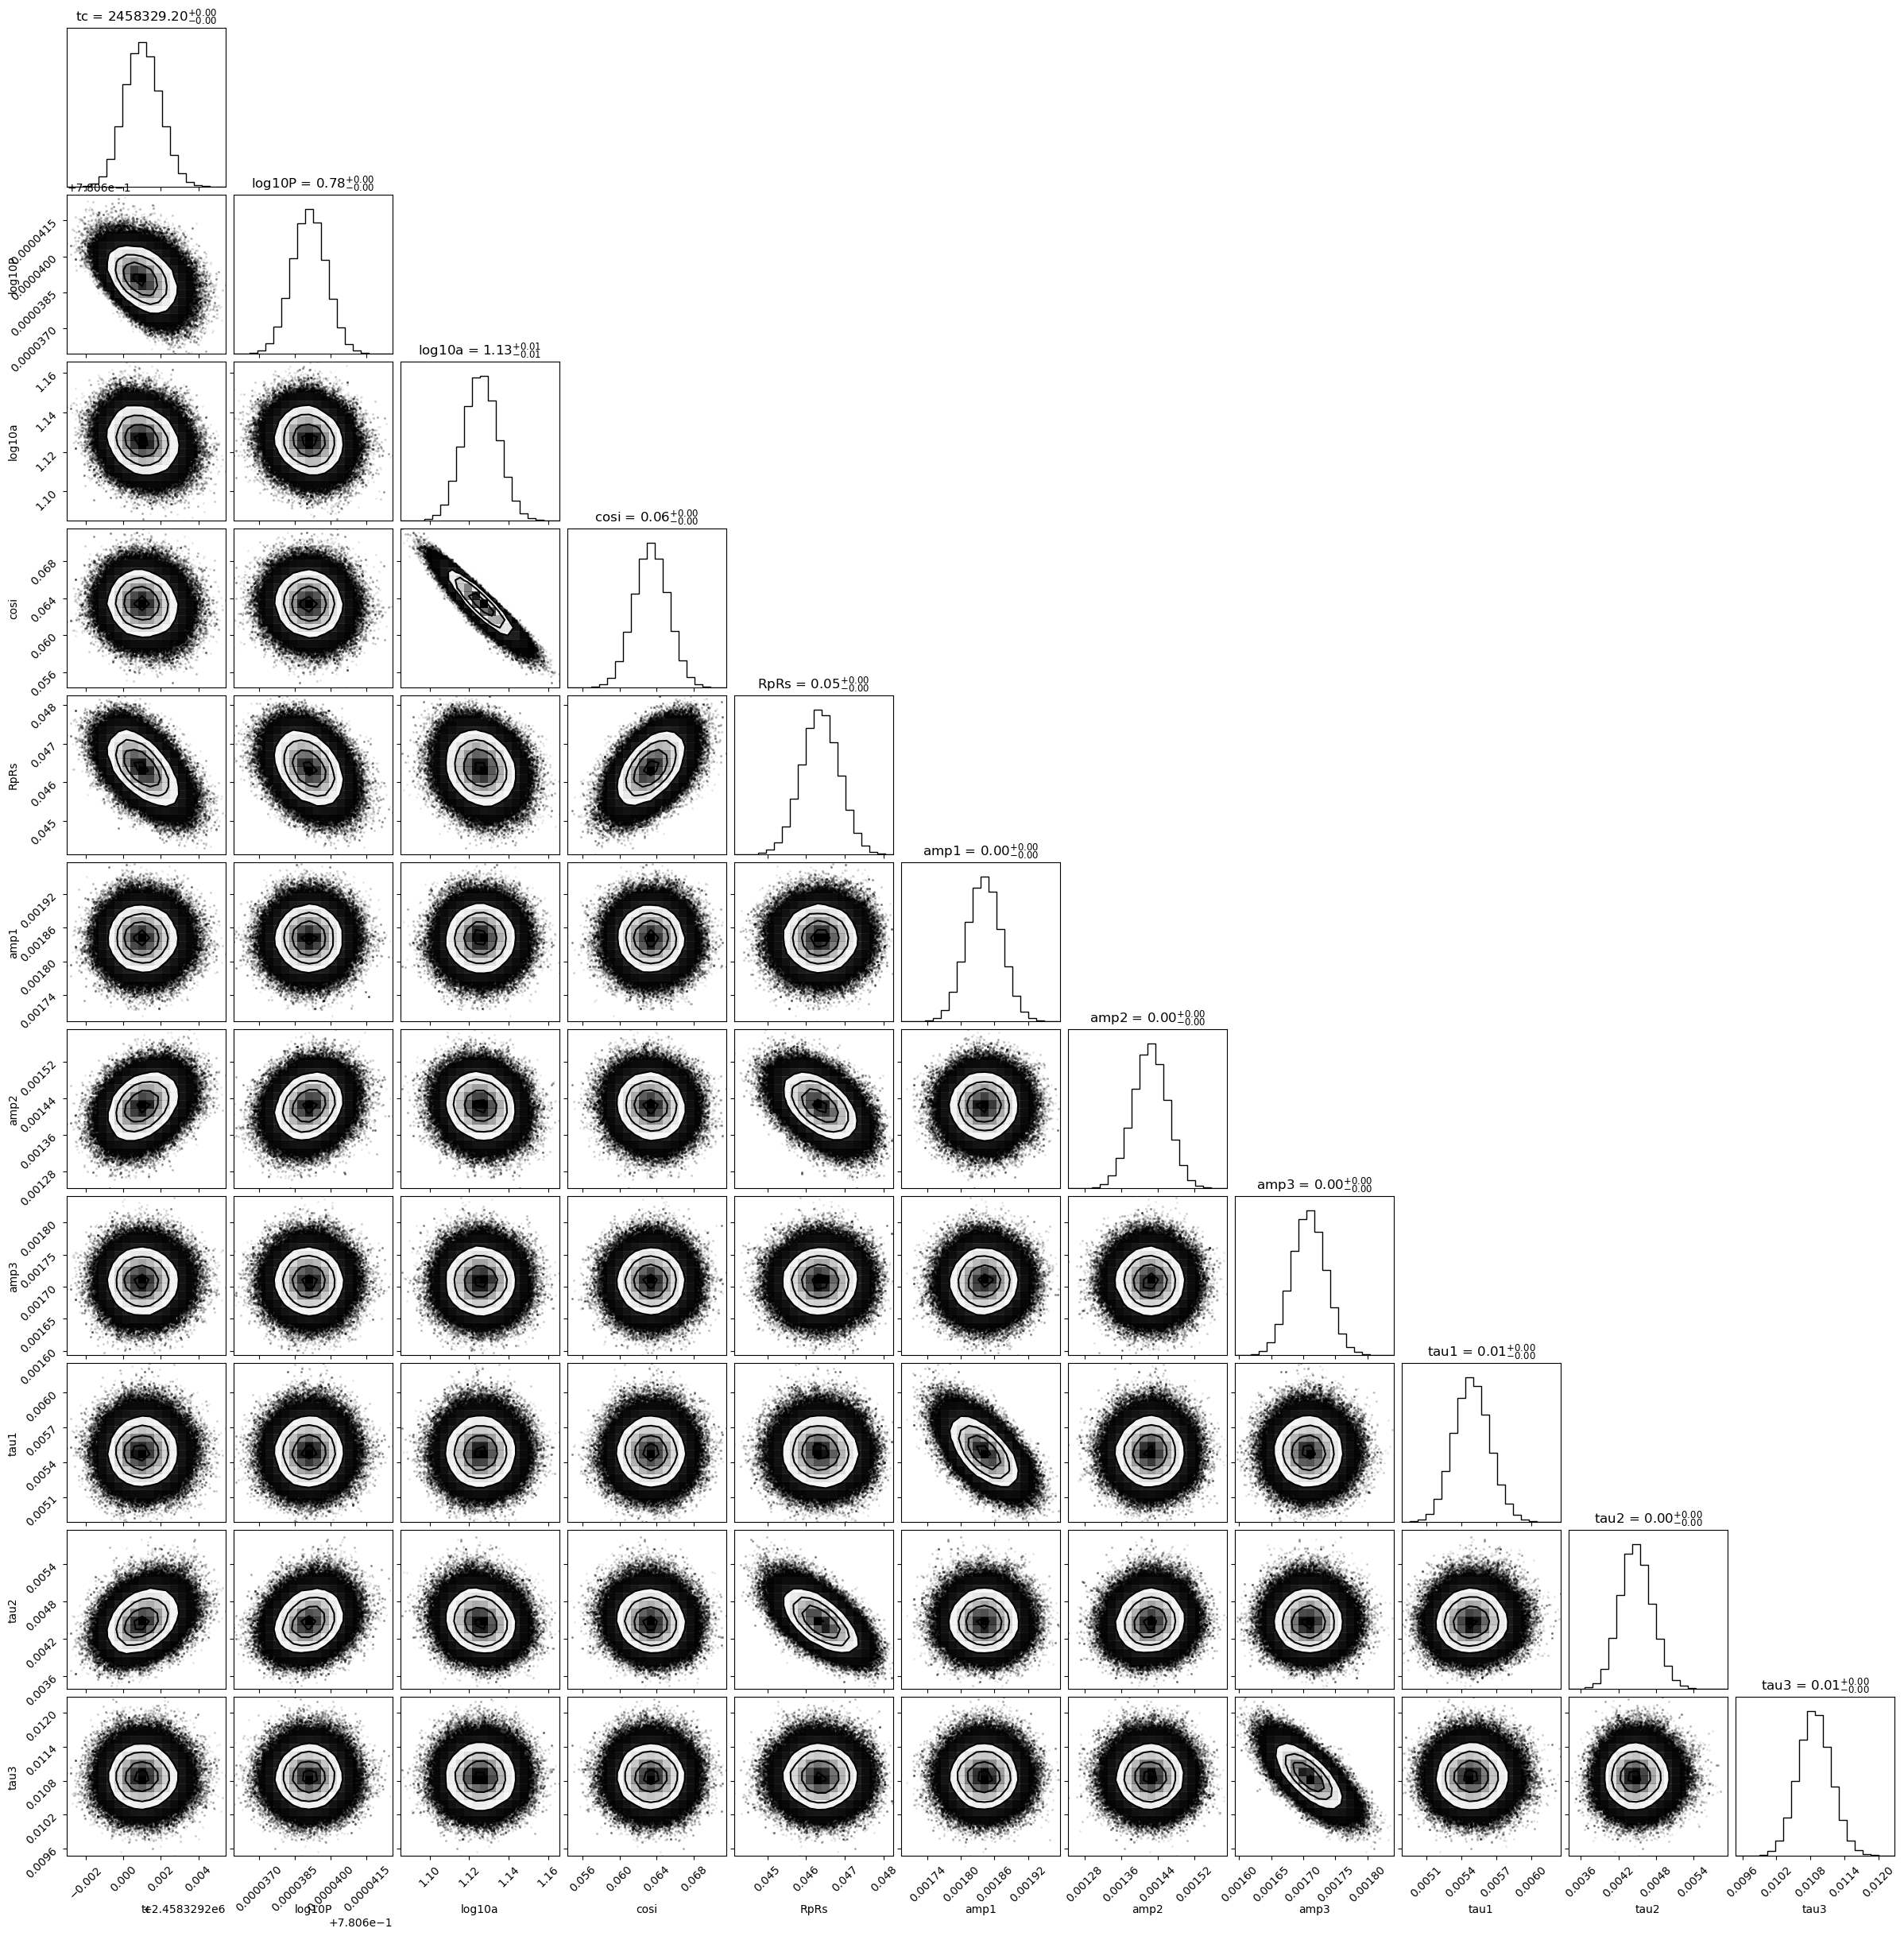

In [53]:
cornerfig = corner.corner(flatsamples, labels=labels, show_titles=True)
plt.show()

In [59]:
print('Best Fit Parameters:')
print(labels)
print(param_fits)

Best Fit Parameters:
['tc' 'log10P' 'log10a' 'cosi' 'RpRs' 'amp1' 'amp2' 'amp3' 'tau1' 'tau2'
 'tau3']
[2.45832920e+06 7.80639092e-01 1.12581928e+00 6.33875011e-02
 4.63634551e-02 1.84109819e-03 1.42383952e-03 1.70842123e-03
 5.48772287e-03 4.48052979e-03 1.08714748e-02]


ln Posterior values:
init =  -3095.0765295665897
best fit =  218.79141391077994
error statistics
mean detrended uncertainty =  3.5598279856980235e-05
mean absolute residual =  8.601083291684027e-05


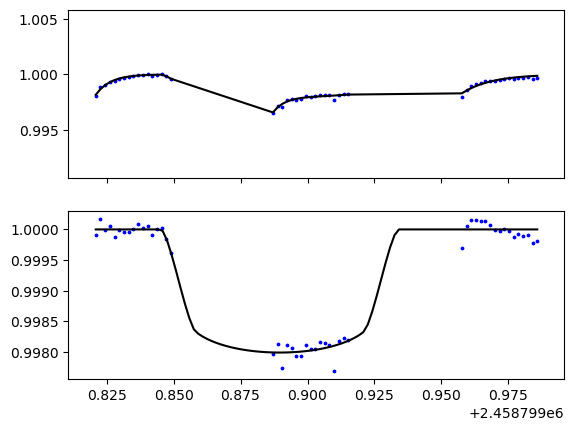

In [62]:
bf_lnPost = lnPosterior(param_fits)
print('ln Posterior values:')
print('init = ', lnPost_init)
print('best fit = ', bf_lnPost)
#print('ratio = ', abs(bf_lnPost)/abs(lnPost_init))

print('error statistics')
print('mean detrended uncertainty = ', np.mean(deterrs))
residuals = fluxes - bf_model
print('mean absolute residual = ', np.mean(abs(residuals)))

fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].scatter(times, fluxes, c='blue', s=3)
ax[0].plot(times, bf_model, c='black')

ax[1].plot(times_smooth, transit_smooth, c='black')
ax[1].scatter(times, detflux, c='blue', s=3)
plt.show()